In [5]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

In [6]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [18]:
url = ("Data/Promedio_de_Apertura_Disney_2008-2018.csv"
)
datos = pd.read_csv(url, sep=";")

In [19]:
datos.head(4)

,Year,Trim,PromAp
0,2008,1,31.89
1,2008,2,32.49
2,2008,3,31.38
3,2008,4,26.06


In [21]:
# Tipo de cada columna
# ==============================================================================

datos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    44 non-null     int64  
 1   Trim    44 non-null     int64  
 2   PromAp  44 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB


In [22]:
# Dimensiones del dataset
# ==============================================================================
datos.shape

(44, 3)

In [23]:
# Número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

Year      0
Trim      0
PromAp    0
dtype: int64

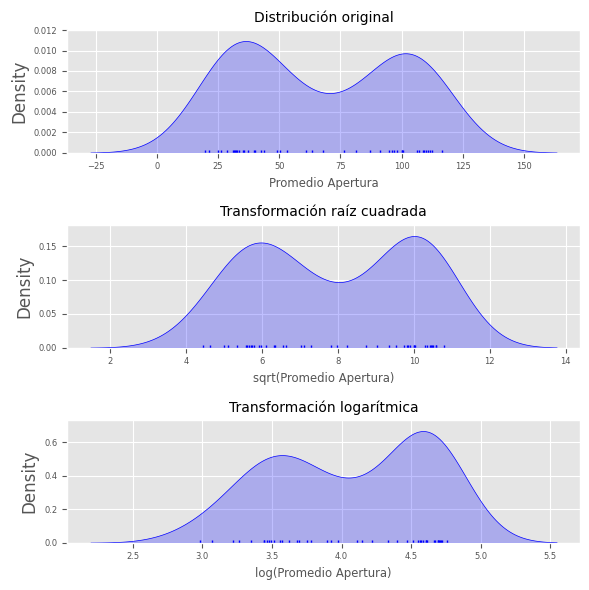

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    datos.PromAp,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    datos.PromAp,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Promedio Apertura', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(datos.PromAp),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(datos.PromAp),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Promedio Apertura)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(datos.PromAp),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(datos.PromAp),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Promedio Apertura)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [25]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(datos.PromAp, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

2024-06-16 17:57:40.748 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.026931)
2024-06-16 17:57:40.765 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.024941)
2024-06-16 17:57:40.805 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted logistic distribution with error=0.027224)
2024-06-16 17:57:40.811 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.027025)
2024-06-16 17:57:40.844 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.027983)
2024-06-16 17:57:40.945 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.025016)
2024-06-16 17:57:40.953 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.027047)
2024-06-16 17:57:40.997 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamm

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.024941,979.558224,983.126603,inf,0.168887,0.144604
chi2,0.025016,968.383765,973.736334,inf,0.172395,0.129734
exponpow,0.026104,1012.273735,1017.626304,inf,0.226472,0.018265
gamma,0.026868,960.576891,965.929460,inf,0.165268,0.161345
norm,0.026931,958.500655,962.069034,inf,0.166872,0.153743
powerlaw,0.027025,953.424843,958.777412,inf,0.238166,0.011125
beta,0.027047,1026.638867,1033.775625,inf,0.251615,0.006092
logistic,0.027224,968.437103,972.005482,inf,0.161333,0.181257
cauchy,0.027983,1022.551980,1026.120359,inf,0.195231,0.060562


In [26]:
# Variables numéricas
# ==============================================================================
datos.select_dtypes(include=['float64', 'int']).describe()


,Year,Trim,PromAp
count,44.000000,44.00000,44.000000
mean,2013.000000,2.50000,66.998182
std,3.198837,1.13096,33.316557
min,2008.000000,1.00000,19.770000
25%,2010.000000,1.75000,34.647500
50%,2013.000000,2.50000,62.205000
75%,2016.000000,3.25000,100.080000
max,2018.000000,4.00000,116.380000


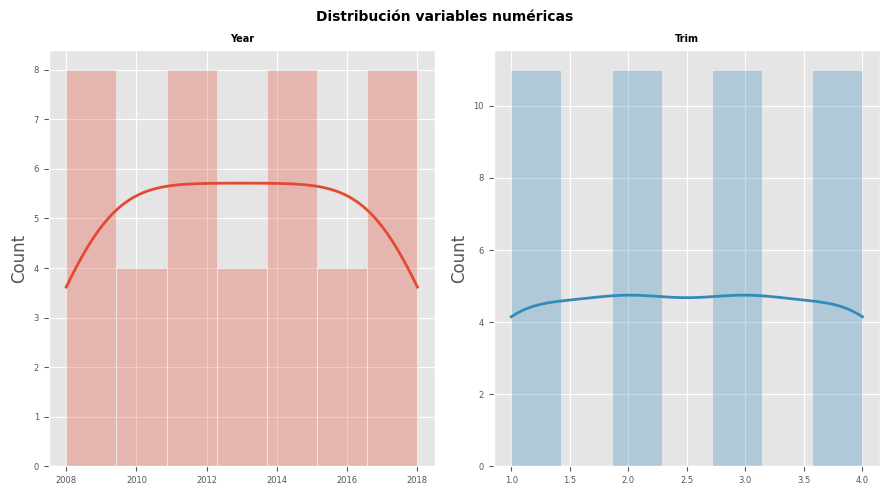

In [29]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('PromAp')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = datos,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

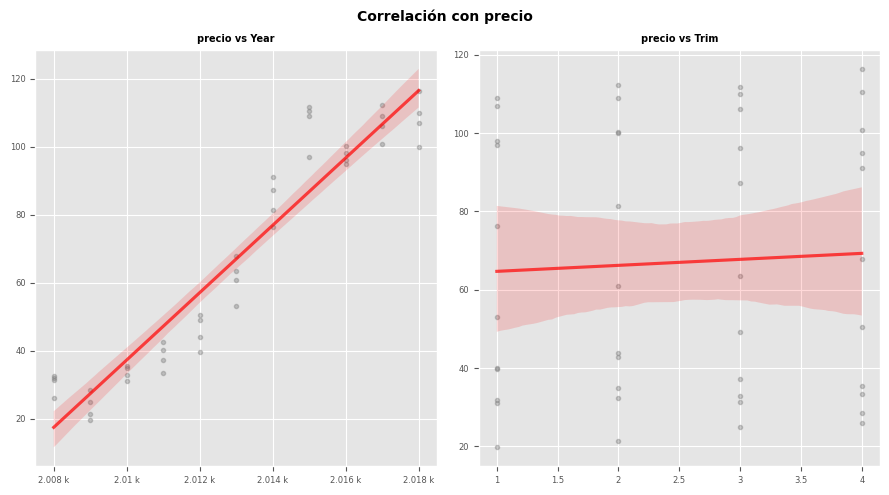

In [36]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('PromAp')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = datos[colum],
        y           = datos['PromAp'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");


In [37]:
# Correlación entre columnas numéricas
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
2,Year,PromAp,9.501817e-01,9.501817e-01
6,PromAp,Year,9.501817e-01,9.501817e-01
5,Trim,PromAp,5.198039e-02,5.198039e-02
7,PromAp,Trim,5.198039e-02,5.198039e-02
1,Year,Trim,-8.244413e-15,8.244413e-15
3,Trim,Year,-8.244413e-15,8.244413e-15


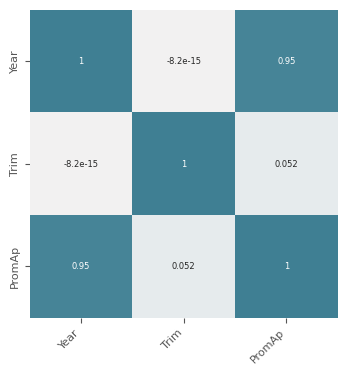

In [38]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [39]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('PromAp', axis = 'columns'),
                                        datos['PromAp'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [40]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count     35.000000
mean      68.804857
std       33.061704
min       21.500000
25%       35.290000
50%       67.960000
75%       99.025000
max      116.380000
Name: PromAp, dtype: float64


In [41]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count      9.000000
mean      59.972222
std       35.366981
min       19.770000
25%       32.870000
50%       43.970000
75%      100.260000
max      108.950000
Name: PromAp, dtype: float64
